In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import torch
plt.rcParams['figure.figsize'] = [18, 12]

In [2]:
imgTensorPath = 'input_1_3_320_320.tensor'
resultTensorPath = 'result_84_2100.tensor'

In [3]:
imgTensor = np.loadtxt(imgTensorPath) * 255

In [4]:
img = imgTensor.reshape(3,320,320).transpose((1,2,0)).astype('uint8')

In [5]:
original_image = img

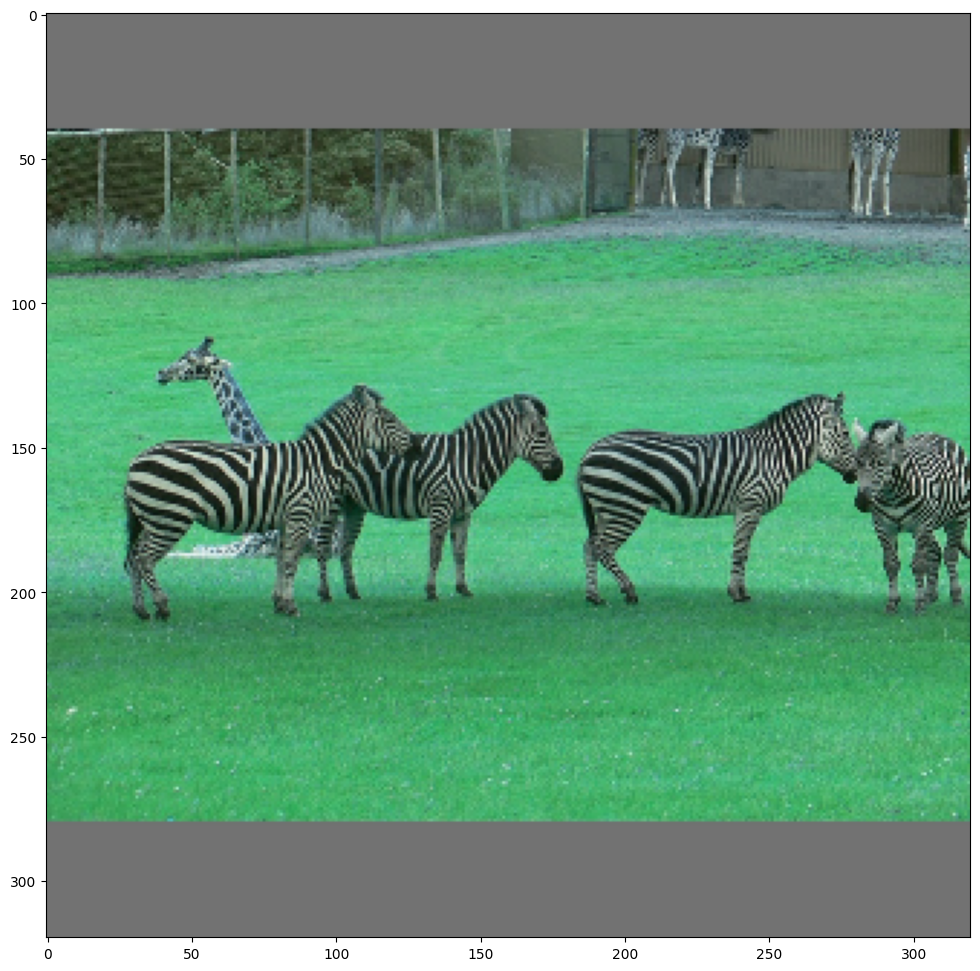

In [6]:
plt.imshow(original_image)
plt.show()

In [7]:
original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)

In [8]:
resultTensor = np.loadtxt(resultTensorPath)

In [9]:
resultTensor = resultTensor.reshape(1, 84, 2100)

In [10]:
outputs=np.array([cv2.transpose(resultTensor[0])])

In [11]:
outputs.shape

(1, 2100, 84)

In [12]:
rows=outputs.shape[1]

In [13]:
boxes = []
scores = []
class_ids = []

# Iterate through output to collect bounding boxes, confidence scores, and class IDs
for i in range(rows):
    classes_scores = outputs[0][i][4:]
    (minScore, maxScore, minClassLoc, (x, maxClassIndex)) = cv2.minMaxLoc(classes_scores)
    if maxScore >= 0.25:
        box = [
            outputs[0][i][0] - (0.5 * outputs[0][i][2]),
            outputs[0][i][1] - (0.5 * outputs[0][i][3]),
            outputs[0][i][2],
            outputs[0][i][3],
        ]
        boxes.append(box)
        scores.append(maxScore)
        class_ids.append(maxClassIndex)

In [14]:
result_boxes = cv2.dnn.NMSBoxes(boxes, scores, 0.25, 0.45, 0.5)

In [15]:
result_boxes

array([26,  4, 10, 28], dtype=int32)

In [16]:
from ultralytics.utils import ASSETS, yaml_load
from ultralytics.utils.checks import check_yaml
CLASSES = yaml_load(check_yaml("coco.yaml"))["names"]

In [17]:
colors = np.random.uniform(0, 255, size=(len(CLASSES), 3))

In [18]:
def draw_bounding_box(image, class_id, confidence, x, y, x_plus_w, y_plus_h):
    """
    Draws bounding boxes on the input image based on the provided arguments.

    Args:
        img (numpy.ndarray): The input image to draw the bounding box on.
        class_id (int): Class ID of the detected object.
        confidence (float): Confidence score of the detected object.
        x (int): X-coordinate of the top-left corner of the bounding box.
        y (int): Y-coordinate of the top-left corner of the bounding box.
        x_plus_w (int): X-coordinate of the bottom-right corner of the bounding box.
        y_plus_h (int): Y-coordinate of the bottom-right corner of the bounding box.
    """
    label = f"{CLASSES[class_id]} ({confidence:.2f})"
    color = colors[class_id]
    cv2.rectangle(image, (x, y), (x_plus_w, y_plus_h), color, 2)
    cv2.putText(image, label, (x - 10, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

In [19]:
detections = []

# Iterate through NMS results to draw bounding boxes and labels
for i in range(len(result_boxes)):
    index = result_boxes[i]
    box = boxes[index]
    detection = {
        "class_id": class_ids[index],
        "class_name": CLASSES[class_ids[index]],
        "confidence": scores[index],
        "box": box,
        "scale": 1,
    }
    detections.append(detection)

In [20]:
for detection in detections:
    box = detection['box']
    scale = detection['scale']
    draw_bounding_box(
        original_image,
        detection['class_id'],
        detection['confidence'],
        round((box[0] - (0)) / 1),
        round((box[1] - (0)) / 1),
        round((box[0] + box[2] - (0)) /1),
        round((box[1] + box[3] - (0)) / 1),
    )

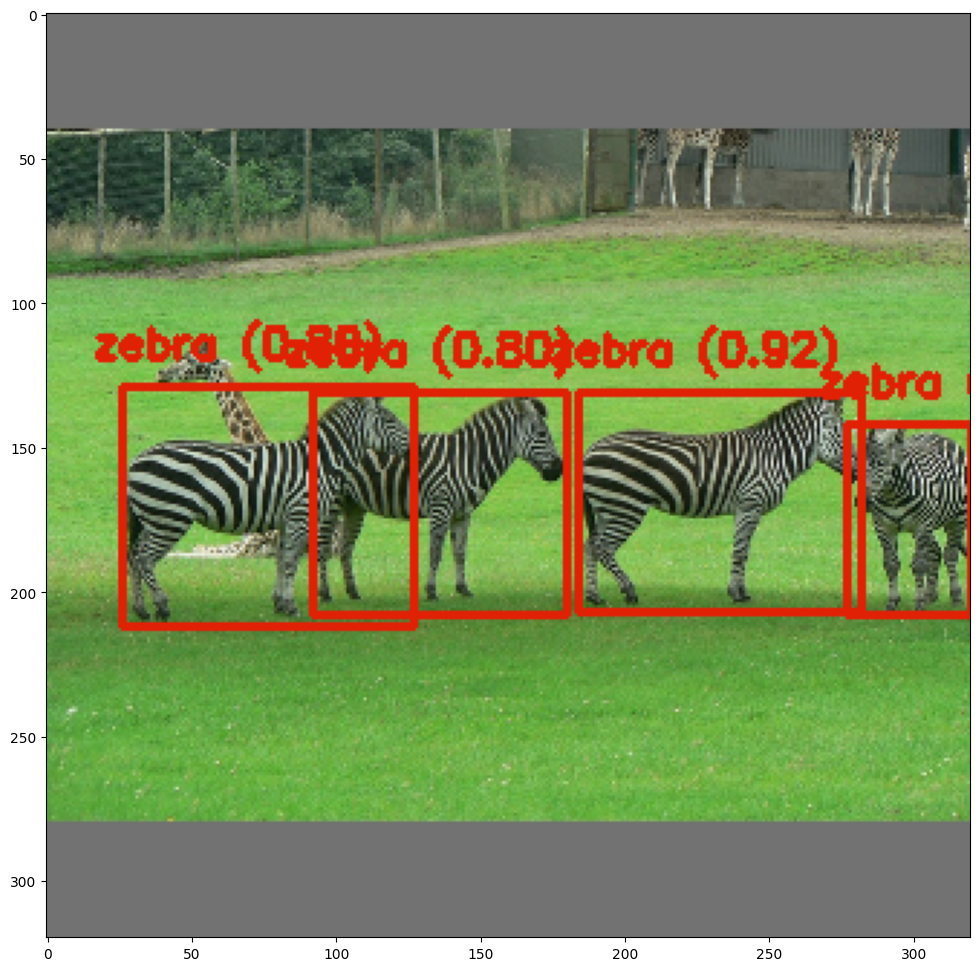

In [21]:
plt.imshow(original_image)
plt.show()